In [27]:
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline


In [28]:
# Sample from a ring 
def sample_data_ring(r = 1, n = 1024, sigma = 0.1):
    theta = np.random.uniform(low=0.0, high=2*np.pi, size=(n,))
    radius = np.random.randn(n) * sigma + r
    x = radius*np.cos(theta)
    y = radius*np.sin(theta)
    return np.stack((x,y),axis = 1)

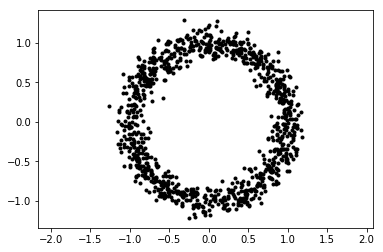

In [29]:
# Visualize data
data = sample_data_ring()
plt.plot(data[:,0],data[:,1],'k.')
plt.axis('equal');

In [30]:
# Sample from a target
def sample_data_target(r = 2, n = 1024, sigma = 0.2):
    n1 = np.ceil(n/2).astype(int)
    n2 = n-n1
    theta1 = np.random.uniform(low=0.0, high=2*np.pi, size=(n1,))
    theta2 = np.random.uniform(low=0.0, high=2*np.pi, size=(n2,))
    radius1 = np.random.randn(n1) * sigma + r
    radius2 = np.random.randn(n2) * 2*sigma 
    x1 = radius1*np.cos(theta1)
    y1 = radius1*np.sin(theta1)
    x2 = radius2*np.cos(theta2)
    y2 = radius2*np.sin(theta2)
    return np.concatenate((np.stack((x1,y1),axis = 1),np.stack((x2,y2),axis = 1)),axis=0)

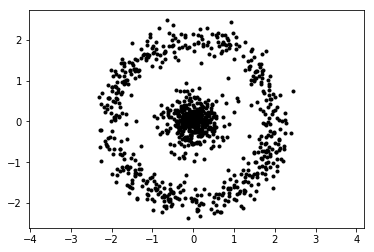

In [6]:
# Visualize data
data = sample_data_target()
plt.plot(data[:,0],data[:,1],'k.')
plt.axis('equal');

In [277]:
def generator(Z, units=[64,64,2], reuse=False):
    with tf.variable_scope("Generator",reuse=reuse):
        h1 = tf.layers.dense(Z,units[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,units[1],activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h2,units[-1])
    return out

In [278]:
def discriminator( X, units=[8,8], reuse=False):
    with tf.variable_scope("Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,units[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,units[1],activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h2,1)
    return out

In [279]:
def sample_Z( shape ):
    z = np.random.normal(0., 1., shape)
    return z

def spiral_Z( num=256 ):
    R = np.linspace(0, 2, num)
    Phi = np.linspace(-2*np.pi, 2*np.pi, num)
    z = np.array([ R * np.cos(Phi), R * np.sin(Phi) ]).T
    return z

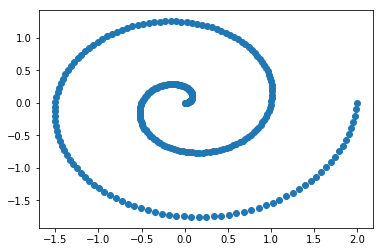

In [280]:
plt.scatter(*spiral_Z().T)

In [281]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [282]:
tf.reset_default_graph()

In [283]:
# Build your graph
# 1. Use "placeholder" as to contruct empty tensors that receive inputs (X and y)
X = tf.placeholder(tf.float32,[None,2])  # None for undetermined number: flexible sample size
Z = tf.placeholder(tf.float32,[None,K])  # None for undetermined number: flexible sample size
Y = tf.placeholder(tf.float32,[None,1])

# 2. Set the grid points into tensorflow constant
# V = tf.constant(v, dtype = tf.float32)

# 3. Pass X through discriminator to obtain logits (linear output)
real_logits = discriminator(X)
X_fake = generator(Z)
fake_logits = discriminator(X_fake, reuse=True)

logits = tf.concat([ real_logits, fake_logits ], axis=0)

# 4. Pass V through discriminator to obtain logits 
# Note: This is the second time using variables in discriminator, so set reuse = True
# v_logits = discriminator(V, reuse=True)

# 5. Write down loss function
# Here I use tensorflow built-in function tf.nn.sigmoid_cross_entropy_with_logits, but one can write the loss function from scratch
# This built-in function deals with numerical instability, see line 109 of the source code
# https://github.com/tensorflow/tensorflow/blob/r1.14/tensorflow/python/ops/nn_impl.py#L108-L185
loss_d = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=Y))
loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits,labels=Y))

# 6. Identify variables for optimization
disc_vars = tf.trainable_variables(scope="Discriminator")
gen_vars = tf.trainable_variables(scope="Generator")

# 7. Set up optimizer (other options: GradientDescentOptimizer, MomentumOptimizer, AdamOptimizer, etc.)
optimizer_d = tf.train.RMSPropOptimizer(learning_rate=0.001)
optimizer_g = tf.train.RMSPropOptimizer(learning_rate=0.001)

# 8. Use "minimize" function to optimize loss by changing the weights of selected variables
opt_d = optimizer_d.minimize(loss_d, var_list = disc_vars)
opt_g = optimizer_g.minimize(loss_g, var_list = gen_vars)



In [ ]:
# Implement training with a tensorflow session
batch_size = 1024
epochs = 10000
K = 2

g_samples = []
r_samples = []
gloss_list = []
dloss_list = []
d_accuracy_list = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        # # #  DISCRIMINATOR  # # #
        z = sample_Z( shape=(batch_size, K) )
        X_batch = sample_data_target(r = 1, n = batch_size, sigma = 0.1)
#         X_batch = sample_data_ring(r = 1, n = batch_size, sigma = 0.1)
        y = np.array( [1]*batch_size + [0]*batch_size )
        # Run one iteration using "run" on optimization step
        # (1) Query variables of interest by calling them in a list with the optimization
        # (2) Use "feed_dict" to feed in samples
        _, this_loss, s_log = sess.run([opt_d, loss_d, logits], feed_dict=\
                                       {X: X_batch, Y: y.reshape(-1,1), Z:z})
         
        # Collect loss and accuracy
        dloss_list.append(this_loss)
        acc = np.mean((sigmoid(s_log)>0.5)==y.reshape(-1,1))
        d_accuracy_list.append(acc)
        r_samples.append(X_batch)

        # # #  GENERATOR  # # #
        z = sample_Z( shape=(batch_size, K) )
        X_batch = sample_data_ring(r = 1, n = 0, sigma = 0.1)
        y = np.array( [1]*0 + [1]*batch_size )
        # Run one iteration using "run" on optimization step
        # (1) Query variables of interest by calling them in a list with the optimization
        # (2) Use "feed_dict" to feed in samples
        _, this_loss, s_log, xf = sess.run([opt_g, loss_g, logits, X_fake], feed_dict=\
                                       {X: X_batch, Y: y.reshape(-1,1), Z:z})
         
        # Collect loss and accuracy
        gloss_list.append(this_loss)
        g_samples.append(xf)

        # keep track of training
        if i%100 == 0 or i == epochs-1:            
            print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f\t Discriminator accuracy: %.4f"%(i,dloss_list[-1],gloss_list[-1],d_accuracy_list[-1]))

    zs = spiral_Z()
    xf_final = sess.run([X_fake], feed_dict={Z:zs})

Iterations: 0	 Discriminator loss: 0.7092	 Generator loss: 0.6806	 Discriminator accuracy: 0.2354
Iterations: 100	 Discriminator loss: 0.7079	 Generator loss: 0.6604	 Discriminator accuracy: 0.3105
Iterations: 200	 Discriminator loss: 0.7202	 Generator loss: 0.6645	 Discriminator accuracy: 0.1641
Iterations: 300	 Discriminator loss: 0.6870	 Generator loss: 0.7189	 Discriminator accuracy: 0.6987
Iterations: 400	 Discriminator loss: 0.6927	 Generator loss: 0.6942	 Discriminator accuracy: 0.3926
Iterations: 500	 Discriminator loss: 0.6894	 Generator loss: 0.7095	 Discriminator accuracy: 0.6162
Iterations: 600	 Discriminator loss: 0.6918	 Generator loss: 0.6954	 Discriminator accuracy: 0.5210
Iterations: 700	 Discriminator loss: 0.6929	 Generator loss: 0.6953	 Discriminator accuracy: 0.4878
Iterations: 800	 Discriminator loss: 0.6916	 Generator loss: 0.6908	 Discriminator accuracy: 0.4814
Iterations: 900	 Discriminator loss: 0.6789	 Generator loss: 0.7227	 Discriminator accuracy: 0.7173
It

In [ ]:
# Plot training losses
plt.plot(gloss_list,linewidth = 1,label='Generator loss')
plt.plot(dloss_list,linewidth = 1,label='Discriminator loss')
# plt.ylim([0,1])
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training losses');
# plt.ylim(0.5,0.8)

In [ ]:
# Plot generated data
plt.scatter(r_samples[-1][:,0],r_samples[-1][:,1], s = 0.5,c = 'r',label='Real data')
plt.scatter(g_samples[-1][:,0],g_samples[-1][:,1], s = 0.5,c = 'b',label='Generated data')
plt.xlim([-3.5,3.5])
plt.ylim([-3.5,3.5])
plt.axis('equal')
plt.legend(frameon=False)
plt.legend(bbox_to_anchor = (1.02,1), loc = 2, borderaxespad = 0.)
plt.title("G loss= %.4f\nD loss= %.4f, D acc= %.4f"%(dloss_list[-1],gloss_list[-1],d_accuracy_list[-1]));

In [ ]:
cm = plt.matplotlib.cm.hsv
col = [ cm(i) for i in np.linspace(0, 1, len(xf_final[0])) ]
plt.scatter(*np.array(xf_final).T, c=col, cmap="Reds", s=15, alpha=0.5)
plt.gca().set_aspect("equal")